# Load datasets from GitHub (raw URLs)
This notebook downloads the CSV files directly from the GitHub repository's `data/` directory and loads them into pandas DataFrames.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Base URL to raw GitHub files
BASE_URL = "https://raw.githubusercontent.com/BaconPotatoCat/inf2008_assignment/refs/heads/main/data/"

# List of CSV files in the data directory
files = [
    "CEAS_08.csv",
    "legit_human.csv",
    "legit_llm.csv",
    "phishing_data_by_type.csv",
    "Phishing_Email.csv",
    "phishing_human.csv",
    "phishing_llm.csv",
    "spam_dataset.csv",
]

def load_csv(url: str) -> pd.DataFrame:
    """Load a CSV robustly by handling bad lines and auto-detecting separators."""
    # Try standard CSV first
    try:
        return pd.read_csv(url)
    except pd.errors.ParserError:
        # Retry with python engine + separator auto-detection
        return pd.read_csv(url, sep=None, engine="python", on_bad_lines="skip")

# Load each CSV into a DataFrame
dataframes = {name: load_csv(BASE_URL + name) for name in files}

# Quick sanity check: show number of rows and columns for each dataset
summary = {name: df.shape for name, df in dataframes.items()}
pprint(summary)


{'CEAS_08.csv': (39154, 7),
 'Phishing_Email.csv': (18650, 3),
 'legit_human.csv': (1000, 7),
 'legit_llm.csv': (1000, 2),
 'phishing_data_by_type.csv': (159, 3),
 'phishing_human.csv': (1000, 7),
 'phishing_llm.csv': (595, 2),
 'spam_dataset.csv': (1000, 2)}


In [45]:
# Show columns and one sample row from each dataset
for name, df in dataframes.items():
    print("\n" + "=" * 80)
    print(f"{name}")
    print("Columns:")
    print(list(df.columns))
    print("Sample row:")
    display(df.head(1))


CEAS_08.csv
Columns:
['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Sample row:


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1



legit_human.csv
Columns:
['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Sample row:


,sender,receiver,date,subject,body,urls,label
0,Jesus Miguel Recuenco Ezquerra <JMRECU@telelin...,handy board <handyboard@media.mit.edu>,2019-10-29 22:53:50,Starting IC with wizard,Hi\n\n\t\tI am running the IR test program fro...,0,0



legit_llm.csv
Columns:
['text', 'label']
Sample row:


,text,label
0,"Dear Michael, I hope this message finds you we...",1



phishing_data_by_type.csv
Columns:
['Subject', 'Text', 'Type']
Sample row:


,Subject,Text,Type
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\...,Fraud



Phishing_Email.csv
Columns:
['Unnamed: 0', 'Email Text', 'Email Type']
Sample row:


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email



phishing_human.csv
Columns:
['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Sample row:


,sender,receiver,date,subject,body,urls,label
0,MetaMask <info@sofamekar.com>,jose@monkey.org,2022-12-27 10:56:49,Your MetaMask wallet will be suspended,Verify your MetaMask Wallet Our system has sho...,1,1



phishing_llm.csv
Columns:
['text', 'label']
Sample row:


,,,,,text,label
Dear User,We have received reports indicating that your account has been flagged for suspicious activities. To ensure the safety of your account and prevent any unauthorized access,we require you to confirm your account details immediately. By clicking on the link below,you will be directed to a secure page where you can update your account information. Failure to comply within the specified timeframe may result in a temporary suspension of your account. chaseonline-login.com Thank you for your cooperation in this matter. Should you have any concerns or questions,please contact our support team urgently. Sincerely,The Account Security Team,1.0



spam_dataset.csv
Columns:
['message_content', 'is_spam']
Sample row:


,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base reg...",0


In [46]:
# Clean each dataset to keep only: body + phishing (binary)

# Column name candidates (normalized to lowercase)
body_candidates = ["body", "text", "email text", "message_content"]
label_candidates = ["label", "type", "email type", "is_spam"]

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df

def find_first_column(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def to_phishing_binary(series: pd.Series, label_col: str) -> pd.Series:
    # Normalize to string for mapping
    s = series.copy()
    if pd.api.types.is_numeric_dtype(s):
        # Assume already binary-ish
        return (s.astype(float) > 0).astype(int)
    s = s.astype(str).str.strip().str.lower()

    if label_col == "type":
        # Only "Phishing" -> 1, else 0
        return (s == "phishing").astype(int)
    if label_col == "email type":
        # Only "Phishing Email" -> 1, else 0
        return (s == "phishing email").astype(int)

    # For other label columns, try numeric coercion (expects 0/1 or similar)
    return pd.to_numeric(s, errors="coerce").fillna(0).astype(float).gt(0).astype(int)

cleaned_dataframes = {}
cleaning_report = {}

for name, df in dataframes.items():
    df_norm = normalize_columns(df)
    cols = list(df_norm.columns)
    body_col = find_first_column(cols, body_candidates)
    label_col = find_first_column(cols, label_candidates)

    if body_col is None or label_col is None:
        cleaning_report[name] = {
            "status": "needs_manual_mapping",
            "columns": cols,
            "body_col": body_col,
            "label_col": label_col,
        }
        continue

    cleaned = pd.DataFrame({
        "body": df_norm[body_col].astype(str),
        "phishing": to_phishing_binary(df_norm[label_col], label_col),
    })

    # Remove rows with missing values or empty body
    cleaned = cleaned.dropna(subset=["body", "phishing"])
    cleaned = cleaned[cleaned["body"].str.strip().astype(bool)].reset_index(drop=True)
    
    # Remove rows containing "Submission-ID"
    cleaned = cleaned[~cleaned["body"].str.contains("Submission-ID", case=False, na=False)].reset_index(drop=True)
    
    cleaned_dataframes[name] = cleaned
    cleaning_report[name] = {
        "status": "ok",
        "rows": len(cleaned),
        "body_col": body_col,
        "label_col": label_col,
    }

# Show cleaning report
pprint(cleaning_report)

{'CEAS_08.csv': {'body_col': 'body',
                 'label_col': 'label',
                 'rows': 39097,
                 'status': 'ok'},
 'Phishing_Email.csv': {'body_col': 'email text',
                        'label_col': 'email type',
                        'rows': 18647,
                        'status': 'ok'},
 'legit_human.csv': {'body_col': 'body',
                     'label_col': 'label',
                     'rows': 955,
                     'status': 'ok'},
 'legit_llm.csv': {'body_col': 'text',
                   'label_col': 'label',
                   'rows': 1000,
                   'status': 'ok'},
 'phishing_data_by_type.csv': {'body_col': 'text',
                               'label_col': 'type',
                               'rows': 159,
                               'status': 'ok'},
 'phishing_human.csv': {'body_col': 'body',
                        'label_col': 'label',
                        'rows': 998,
                        'status': 'ok'},
 'phishin

In [47]:
# Combine all cleaned datasets into one DataFrame
combined_df = pd.concat(cleaned_dataframes.values(), ignore_index=True)

# Drop duplicate email bodies
combined_df = combined_df.drop_duplicates(subset=["body"], keep="first").reset_index(drop=True)

print(f"Combined rows: {len(combined_df)}")
display(combined_df.head())

Combined rows: 59266


,body,phishing
0,"Buck up, your troubles caused by small dimensi...",1
1,\nUpgrade your sex and pleasures with these te...,1
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Would anyone object to removing .so from this ...,0
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


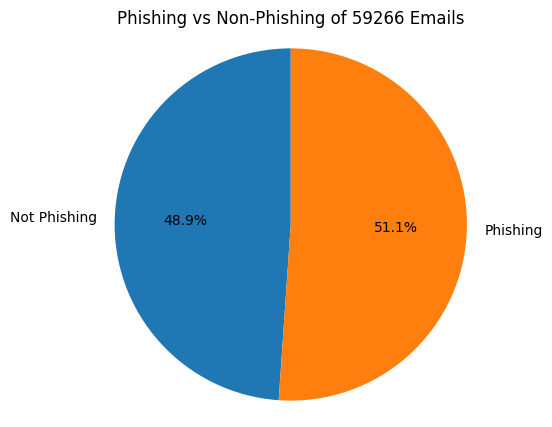

In [48]:
# Plot phishing distribution as a pie chart

counts = combined_df["phishing"].value_counts().sort_index()
labels = ["Not Phishing", "Phishing"] if list(counts.index) == [0, 1] else [str(i) for i in counts.index]

plt.figure(figsize=(5, 5))
plt.pie(counts.values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title(f"Phishing vs Non-Phishing of {len(combined_df)} Emails")
plt.axis("equal")
plt.show()

In [49]:
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
combined_df["body"] = combined_df["body"].apply(preprocess_text)


In [50]:
# Save to CSV
combined_df.to_csv('./data/combined_phishing_emails.csv', index=False)

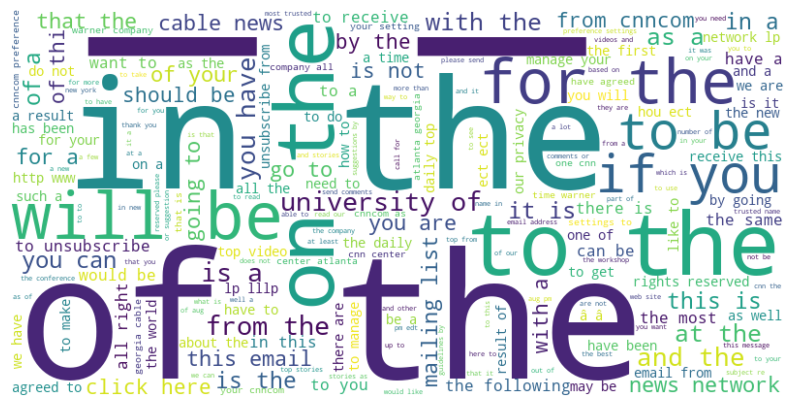

In [51]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails = " ".join(combined_df['body'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

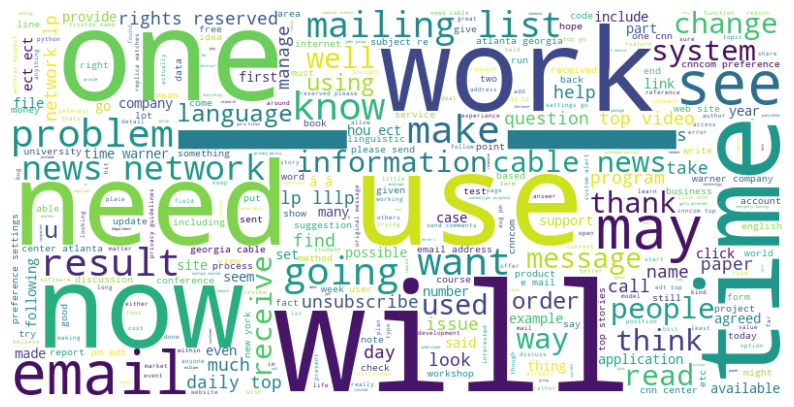

In [52]:
#combine all rows into a single string
all_mails = " ".join(combined_df['body'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(stop_words="english",max_features=10000) #dimension reduction

feature_x = tf.fit_transform(combined_df["body"]).toarray()

In [54]:
y_tf = np.array(combined_df["phishing"]) # convert the label into numpy array


In [55]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.7,random_state=0)

In [56]:
#naive bayes works with condtional probability
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


accuracy from native bayes: 94.94 %
f1 score from naive bayes: 94.84 %
classification report :

               precision    recall  f1-score   support

           0       0.92      0.99      0.95      8728
           1       0.99      0.91      0.95      9052

    accuracy                           0.95     17780
   macro avg       0.95      0.95      0.95     17780
weighted avg       0.95      0.95      0.95     17780



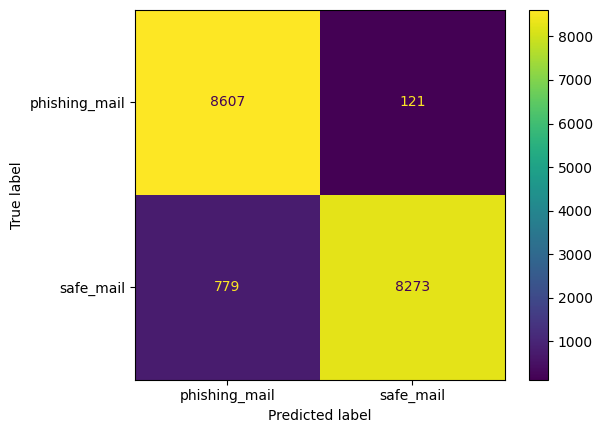

In [57]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
pred_nav = nb.predict(x_test)

# Checking the performance

print(f"accuracy from native bayes: {accuracy_score(y_test,pred_nav)*100:.2f} %")
print(f"f1 score from naive bayes: {f1_score(y_test,pred_nav)*100:.2f} %")
print("classification report :\n\n",classification_report(y_test,pred_nav))

#confusion matrix
clf_nav = confusion_matrix(y_test,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['phishing_mail','safe_mail']).plot()
plt.show()


accuracy from logistic regression:97.92 %
f1 score from logistic regression: 97.97 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      8728
           1       0.98      0.98      0.98      9052

    accuracy                           0.98     17780
   macro avg       0.98      0.98      0.98     17780
weighted avg       0.98      0.98      0.98     17780



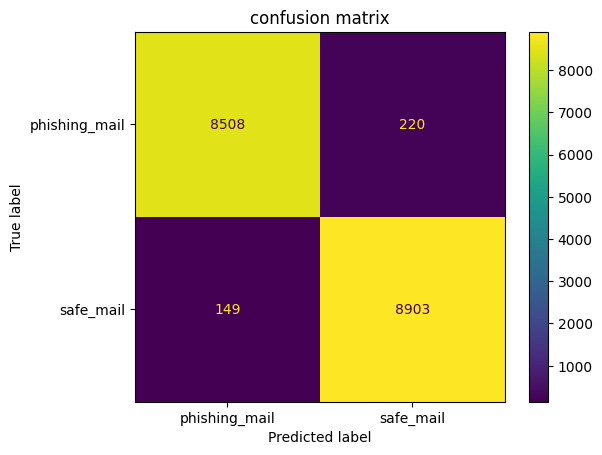

In [58]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(x_train,y_train)

# prediction
pred_lg = lg.predict(x_test)
# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_lg)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_lg))

clf_lg = confusion_matrix(y_test,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

accuracy from Decision Tree:94.65 %
f1 score from Decision Tree: 94.76 %
classification report : 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      8728
           1       0.94      0.95      0.95      9052

    accuracy                           0.95     17780
   macro avg       0.95      0.95      0.95     17780
weighted avg       0.95      0.95      0.95     17780



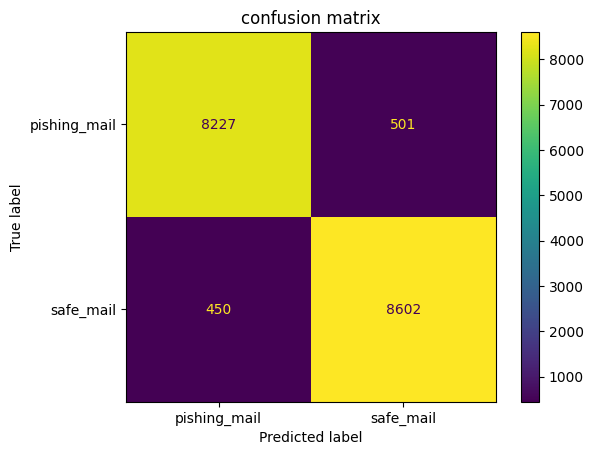

In [62]:
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier() #passing object
dtr.fit(x_train,y_train)

#prediction
pred_dtr = dtr.predict(x_test)

#performance
print(f"accuracy from Decision Tree:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"f1 score from Decision Tree: {f1_score(y_test,pred_dtr)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_dtr))

#confusion matrix
clf_dtr = confusion_matrix(y_test,pred_dtr)
cx_ = ConfusionMatrixDisplay(clf_dtr,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

accuracy from rnadom forest:97.29 %
f1 score from random forest: 97.31 %
classification report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8728
           1       0.98      0.96      0.97      9052

    accuracy                           0.97     17780
   macro avg       0.97      0.97      0.97     17780
weighted avg       0.97      0.97      0.97     17780



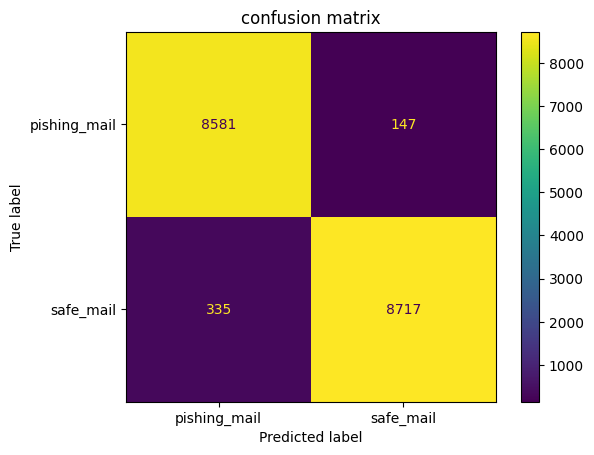

In [63]:
from sklearn.ensemble import RandomForestClassifier

rnf = RandomForestClassifier() #passing object
rnf.fit(x_train,y_train)

#prediction
pred_rnf = rnf.predict(x_test)

#performance
print(f"accuracy from rnadom forest:{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"f1 score from random forest: {f1_score(y_test,pred_rnf)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_rnf))

#confusion matrix
clf_rnf = confusion_matrix(y_test,pred_rnf)
cx_ = ConfusionMatrixDisplay(clf_rnf,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()